In [1]:
import pandas as pd
from fuzzywuzzy import fuzz
import jellyfish
import numpy as np
from geopy.geocoders import Nominatim, GoogleV3
import pickle
import spacy
import string
import operator
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("1hb_2014.csv")
print("List of columns for reference")
df.columns

List of columns for reference


Index(['lca_case_number', 'status', 'lca_case_submit', 'decision_date',
       'visa_class', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'lca_case_employer_name',
       'lca_case_employer_address', 'lca_case_employer_city',
       'lca_case_employer_state', 'lca_case_employer_postal_code',
       'lca_case_soc_code', 'lca_case_soc_name', 'lca_case_job_title',
       'lca_case_wage_rate_from', 'lca_case_wage_rate_to',
       'lca_case_wage_rate_unit', 'full_time_pos', 'total_workers',
       'lca_case_workloc1_city', 'lca_case_workloc1_state', 'pw_1',
       'pw_unit_1', 'pw_source_1', 'other_wage_source_1', 'yr_source_pub_1',
       'lca_case_workloc2_city', 'lca_case_workloc2_state', 'pw_2',
       'pw_unit_2', 'pw_source_2', 'other_wage_source_2', 'yr_source_pub_2',
       'lca_case_naics_code'],
      dtype='object')

# Warm Up - Question 1

Problem definition:

1. Which companies applied for the largest number of H­1B visas where the job opening was located in NYC? Please describe any issues you may encounter summarizing the data by employer name.

Solution:

There were many issues with this dataset.  The first of these problems was just deciding on what is semantically considered New York City.  Technically New York City is all 5 borroughs, which should be fine.  But the fields `lca_case_workloc1_city` and `lca_case_workloc2_city` which stores the locations of the job openning have multiple values that map semantically to something that is reasonable to describe as New York City.

As you can see below, I enumerated all the possible choices for location in the 5 borroughs.  First I segmented the data into only New York state. 

In [40]:
first_work_location = df[df["lca_case_workloc1_state"] == "NY"]
second_work_location = df[df["lca_case_workloc2_state"] == "NY"]
loc1_cities = list(set(first_work_location["lca_case_workloc1_city"]))
loc2_cities = list(set(second_work_location["lca_case_workloc2_city"]))
total_cities = list(set(loc1_cities + loc2_cities))
total_cities = [city for city in total_cities if city is not np.nan]
len(total_cities)

765

Because the number of total city names was small it was relatively easy to figure out all locations that belonged in new york city proper. First I looked for any city names that had new in them and copied those names that clearly meant new york city into a list in a cell below and named the list `new_york_city_names`

In [41]:
for city in total_cities:
    if "NEW" in city:
        print(city)

NEW YROK
SLEEPY HOLLOW, NEW YORK
NEW YORK, 10003
NEWYORK
NEW WINDSOR
CITY OF NEW YORK
BRONX.NEW YORK
NEW PALTZ
NEW HYDE PARK
NEW YORK, NY -
NEW YORK NY
NEW HAMPTON
NEWBURGH
NEW BERLIN
METRO NEW YORK
NEW HARTFORD
NEW ORK
NEW YOK
MANHATTAN, NEW YORK
NEW YORK
NEW TORK
NEW YOUR
BRIDGEPORT / NEW YORK
NEW YORK CITY
NEWARK
BRONX,NEW YORK
NEWYORK CITY
NEW YORK, NEW YORK
NEW CITY
NEW YORK,NEW YORK
NEW
NEW YORK, NY
NEW WINDSOW
NEW YOURK
NEW ROCHELLE
NEW YORK,
NEW YORK CITY,
BRONX, NEW YORK


Then I looked around for other obvious New York City locations.  The next thing I did was get a bounding box for New York City from this site: https://www.mapdevelopers.com/geocode_bounding_box.php

Using that bounding box, I made use of geopy to map the city names, to the lat longs.  If the lat longs were inside the bounding box, then I considered adding it to the list:

In [62]:
google_api_key = pickle.load(open("google_geocoder_api.creds","rb"))
locations = []
google_encoder = GoogleV3(google_api_key)
nominatim_encoder = Nominatim()
city_indexes = []
for index, city in enumerate(total_cities):
    if "NY" not in city:
        text = city +",NY"
    else:
        text = city
    try:
        locations.append(google_encoder.geocode(text))
        city_indexes.append(index)
    except:
        locations.append(nominatim_encoder.geocode(text))
        city_indexes.append(index)

In [64]:
north_lat = 40.917577 
south_lat = 40.477399 
east_long = abs(-73.700272)
west_long = abs(-74.259090)
locations = [elem for elem in locations if elem]
for index,location in enumerate(locations):
    lat_check = False
    long_check = False
    if location.latitude < north_lat and location.latitude > south_lat:
        lat_check = True
    if abs(location.longitude) < west_long and abs(location.longitude) > east_long:
        long_check = True
    if lat_check and long_check:
        city_index = city_indexes[index]
        print(total_cities[city_index])

COLLEGE POINT
NEW YROK
DOUGLASTON
MASPETH
NEW YORK, 10003
SUITE 945
137 VARICK STREET, 2ND FLOOR
ELMHURST
NEWYORK
LONG ISLAND CITY
6TH FLOOR, ROOM 6027W
WHITETONE
GLEN OAKS
OAKLAND GARDENS
OZONE PARK
FLUSHING
JAMAICA
MIAMI
55 WATER STREET
CITY OF NEW YORK
LONG ISLANDY CITY
BRIARWOOD
LONGISLAND CITY
325 HUDSON STREET, 9TH FLOOR
BRONX,NY
BRONX.NEW YORK
CHELSEA
6TH FLOOR
160 CONVENT AVENUE
ROCHDALE VILLAGE
MT. VERNON
WOODSIDE
GREAT NECK,
NEW YORK, NY -
REGO
850 12TH AVENUE
LAURELTON
OAKLAND GARDEN
EAST ELMHURST
NEW YORK NY
BELLEVUE
43-34 32ND PLACE
LONG ISLAND CITY, QUEENS
GLENDALE
KEW GARDENS
WILLIAMSBURGH
METRO NEW YORK
RIVERDALE
BOWLING GREEN
SOUTH RICHMOND HILL
FRESH MEADOWS
ELMHRUST
WOODMERE
SUITE NO 1502
JAMAICA, NY
STATEN ISLAND
MIDDLE VILLAGE
LONG ISLAND CTY
JACKSON HEIGHTS
NEW ORK
MOUNT VERNON
1 COURT SQUARE
FOREST HILLS
NEW YOK
THROGGS NECK
CHICAGO
MANHATTAN, NEW YORK
SUITE 1802
ST. ALBANS
LIC
RIDGEWOOD
DOWNTOWN BROOKLYN
FOREST HILLS QUEENS
BOISE
JAMIACA
BRONX
SUITE 514
NEW YORK

From this list of 180 results - far smaller than the original lists length of 765, I googled or visually inspected each result.  If the result was a place I knew in New York City, I added it to the list.  If it didn't look familiar I googled it.  Those results that made it through this last test ended up in the list below, stored in a variable called `new_york_city_names`.

In [3]:
new_york_city_names = [
    "NEW YORK,", "BAYSIDE", "1 COURT SQUARE",
    "160 FORT WASHINGTON AVENUE", "ASTORIA",
    "LONG IS CITY", "RIDGEWOOD", "BROOKYLN",
    "160 CONVENT AVENUE", "227 EAST 56TH STREET",
    "SOUTH OZONE PARK", "BROOKLY", "LONG ISLAND CTY",
    "DOWNTOWN BROOKLYN", "BRONX,NEW YORK", "5 TIMES SQUARE",
    "MANHATTAN", "MANHATAN", "BROOKLYN,", "BROOKLN",
    "MEW YORK", "BRONX", "132 HARRISON PLACE",
    "LONGISLAND CITY", "NEW YORK", "MIDTOWN MANHATTAN",
    "METRO NEW YORK", "NEW YOUR", "BROOKYN",
    "NEW YORK, 10003", "BROOKLYN", "NEW TORK",
    "650 WEST 168TH STREET", "325 HUDSON STREET, 9TH FLOOR",
    "FORREST HILLS", "BRONX.NEW YORK", "CITY OF NEW YORK",
    "JACKSON HEIGHTS", "FLUSHING", "THROGGS NECK",
    "QUEENS VILLAGE", "NEW ORK", "JOHNSON STREET",
    "ROCKAWAY PARK", "LONG ISLAND CITY, QUEENS",
    "NEW YORK,NEW YORK", "MANHATTAN BEACH",
    "NEW YORK, NEW YORK", "NEW YORK CITY",
    "NEWYORK CITY", "S RICHMOND HILL",
    "L.I.C.", "RICHMOND HILL", "55 WATER STREET",
    "OZONE PARK", "LONG ISLANDY CITY", "JAMAICA",
    "INWOOD", "SUNNYSIDE", "NEW YORK NY",
    "CAMBRIA HEIGHTS", "NEW YORK CITY,",
    "THROGS NECK", "137 VARICK STREET, 2ND FLOOR",
    "#35620 OZONE PARK NY MSA", "JAMAICA, NY",
    "LONG ISLAND CITY,", "NEW YOURK", "NY",
    "NEWYORK", "YORKERS", "NEW YROK",
    "LIC", "13 W.100TH STREET, APT. 4B",
    "850 12TH AVENUE", "NEW YOK",
    "701 WEST 168TH STREET", "FLUSHING, NY",
    "630 WEST 168TH STREET", "FOREST HILLS",
    "BOWLING GREEN", "NEW YORK, NY -", "LITTLE NECK",
    "NEW YORK, NY", "43-34 32ND PLACE",
    "LONG ISLAD CITY", "REGO PARK",
    "MANHATTAN, NEW YORK", "BRONX,NY",
    "LONG ISLAND CITY", "NYC",
    "QUEENS", "YONKERS", "BRONX, NEW YORK"
]

len(new_york_city_names)

94

Next I segmented by city data by names I knew to be within new york city.  Anything not in the city was removed.  I visually checked to make sure the test worked by calling the first 5 entries.

In [4]:
def segment_to_nyc(x):
    if x in new_york_city_names:
        return True
    else:
        return False

nyc = df[df["lca_case_workloc1_city"].apply(segment_to_nyc)]
nyc.head()

,lca_case_number,status,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,other_wage_source_1,yr_source_pub_1,lca_case_workloc2_city,lca_case_workloc2_state,pw_2,pw_unit_2,pw_source_2,other_wage_source_2,yr_source_pub_2,lca_case_naics_code
23,I-200-09259-849209,CERTIFIED,2014-03-12,2014-03-18,H-1B,2014-09-10,2017-09-10,"FRS AMERICA, INC.",2700 LAKE COOK ROAD,RIVERWOODS,...,OFLC ONLINE DATA CENTER,2013.0,NEW YORK,NY,129418.0,Year,OES,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,511210.0
36,I-200-09300-229787,CERTIFIED-WITHDRAWN,2013-09-11,2014-04-10,H-1B,2014-02-28,2015-03-31,FITCH RATINGS,ONE STATE STREET PLAZA,NEW YORK,...,OFLC ONLINE DATA CENTER,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,523930.0
43,I-200-09321-521235,CERTIFIED-WITHDRAWN,2012-05-02,2014-08-21,H-1B,2012-05-11,2015-05-10,BARCLAYS CAPITAL INC.,745 SEVENTH AVENUE,NEW YORK,...,OFLC ONLINE DATA CENTER,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,523110.0
62,I-200-10022-756568,CERTIFIED,2013-10-24,2013-11-01,H-1B,2013-10-24,2016-10-22,"BLACKROCK INVESTMENT MANAGEMENT, LLC",40 EAST 52ND STREET,NEW YORK,...,OFLC ONLINE DATA CENTER,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,523920.0
98,I-200-10106-798993,CERTIFIED,2014-05-20,2014-05-27,H-1B,2014-10-01,2017-09-30,"F.O. USA, INC.",410 COLUMBUS AVENUE,NEW YORK,...,OFLC ONLINE DATA CENTER,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448130.0


The next thing to do was look into employer names.  Knowing from the location data, that this data set is quiet messy I tried to come up with a scheme for canonicalizing the names of employers.  In order to do this efficiently I had to do a bit of messing around.  The first thing to note is the companies sometimes have different names, but refer to the same "actual" company.  I'm being a bit hand wavy here, but a good example of what I'm talking about presents itself with morgan stanley.  If you run the below code and then access the `employer_counts` dict like so:

```
>>> for elem in employer_counts:
...     if "MORGAN" in elem:
...             print(elem)
... 
MORGAN STANLEY SMITH BARNEY
MORGAN STANLEY BANK NA
MORGAN STANLEY CAPITAL GROUP
MORGAN STANLEY FUND SERVICES
MORGAN STANLEY INVESTMENT MANAGEMENT
MORGAN LEWIS BOCKIUS
MORGAN STANLEY BANK
MORGANE LE FAY
MORGANS HOTEL GROUP MANAGEMENT
```

We see that there are at least 4 businesses that are actually Morgan Stanley, as a lay person would think of it.  So it's probably best to be able to group by this natural categorization.

Digging in a bit to the code - one of the things you'll notice about `clean_split` - my preprocessing function, I remove some obvious words that are likely to appear quiet a bit.  Since these are company names, they add little value to the canonicalization process, therefore they are removed.  The next thing to note is my use of named entity recognition from `spacy`.  There entity tagger allows me to remove useless common words.  If the label "ORG" is attached to the entity, we simply include that in names to check.  

Stepping back a bit, to see what the overall goal of the code is - the high level goal is simple, determine which businesses occur multiple times, under slightly different names.  If we knew all the semantic organizations, like we know MORGAN STANLEY then we could simply check for that sub-string in all the other business names.  Unfortunately we don't, so we simply try to mimic that functionality generally, via these `ORG` entities we pulled out earlier.  Looping over each word, checking for each substring we believe to be an `ORG`, we are able to approximate what all the unique employer names are.  These are stored in the keys of `employer_counts`.  

In [144]:
def clean_split(employer):
    translations = [employer.maketrans(elem," ") for elem in string.punctuation]
    stop_words = ["INC", "LLC", "&", "PC", "LP", "LLP", "CO", "LTD", "CORP"]
    for translation in translations:
        employer = employer.translate(translation)
    employer = ''.join(employer)
    return [elem for elem in employer.split() if elem not in stop_words]
    
nlp = spacy.load('en')
nyc = df[df["lca_case_workloc1_city"].apply(segment_to_nyc)]
employers = list(nyc["lca_case_employer_name"].unique())
employer_counts = {}
for index, employer in enumerate(employers):
    other_employers = employers[:index] + employers[index+1:]
    names = clean_split(employer)
    names = [name for name in names if len(name) > 1]
    names = [name for name in names if not name.isdigit()]
    doc = nlp(' '.join(names))
    names = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    tmp = {}.fromkeys(names, 0)
    for name in names:
        tmp[name] += sum([employer.count(name) for employer in other_employers])
    employer_counts.update(tmp)

print(max(employer_counts.items(), key=operator.itemgetter(1)))

counter = 0
for employer in employer_counts:
    if employer_counts[employer] < 100:
        counter += 1
counter

('CA', 1357)


3256

Notice that some employer names occur quiet frequently - for instance, the most common is "CA".  Clearly "CA" is not a company name.  So we look for employers with counts less than 100 to try to thin out any obvious errors:

In [161]:
duplicates = []
uniques = []
for employer in employer_counts:
    if employer_counts[employer] == 1:
        uniques.append(employer)
    else:
        duplicates.append(employer)
print("Uniquely appearing companies",len(uniques))
print("Companies appearing more than once",len(duplicates))

Uniquely appearing companies 302
Companies appearing more than once 2958


From here we can see which companies appear more than once.  So all we need to do now is work over the duplicates, creating canonical names for each.  Then we can map the duplicate names to their canonical names.

In [185]:
def compare_companies(company_one, company_two):
    stop_words = ["INC", "LLC", "&", "PC", "LP", "LLP", "CO", "LTD", "CORP",
                "MANAGEMENT", "CAPITAL", "SERVICES", "BANK", "PLC", "FINANCIAL"
                 "NEW", "YORK", "DEPARTMENT", "UNIVERSITY"]
    company_one_words = [word for word in company_one.split() if word not in stop_words]
    company_two_words = [word for word in company_two.split() if word not in stop_words]
    common_words = 0
    for c1_word in company_one_words:
        for c2_word in company_two_words:
            if c1_word == c2_word:
                common_words += 1
    percent_common_words = common_words / len(company_two.split())
    if percent_common_words > 0.4:
        return True
    else:
        return False
    
mapping = {}
for index, company in enumerate(duplicates):
    if company not in list(mapping.keys()):
        other_companies = duplicates[:index] + duplicates[index+1:]
        for other_company in other_companies:
            if compare_companies(company, other_company):
                mapping[other_company] = company
len(mapping)

1081

In [184]:
keys = list(mapping.keys())
for ind, key in enumerate(keys):
    print(key, "==", mapping[key])
    if ind == 200:
        break

BARCLAYS SERVICES == BARCLAYS CAPITAL ENERGY
EURO RSCG NEW YORK == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
INTERNATIONAL HOUSE NEW YORK == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
THE BANK OF NEW YORK MELLON == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
DEUTSCHE BANK NEW YORK == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
NEW YORK UNIVERSITY HOSPITALS CENTER == NEW YORK UNIVERSITY SCHOOL OF MEDICINE
NEW == NEW METRO CONSTRUCTION
NEW YORK TECHNOLOGY PARTNERS == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
NEW YORK UNIVERSITY == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
YESHIVA UNIVERSITY == YESHIVA
TARDIS GROUP NEW YORK == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
THE CITY UNIVERSITY OF == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
NEW YORK FOUNDATION == THE NEW YORK CITY DEPARTMENT OF HEALTH AND MENTAL
FORDHAM UNIVERSITY == THE AMERICAN UNIVERSITY IN CAIRO
NEW YORK INSTITUTE OF ENGLISH AND BUSINESS == CHUNG TE INSTITUTE OF REL

Despite my best efforts I could not create a satisfactory categorization for businesses, mapping them to unique names.  So I will simply treat each of these businesses as seperate entities, both legally and semantically.

Returning to the question at hand:

To get the companies which applied for the largest number of H1B-visas I simply did the following:

In [72]:
from collections import OrderedDict
h1b_nyc = nyc[nyc["visa_class"] == "H-1B"]
employers = list(h1b_nyc["lca_case_employer_name"].unique())
value_counts = {}.fromkeys(employers, 0)
for employer in employers:
    tmp_df = h1b_nyc[h1b_nyc["lca_case_employer_name"] == employer]
    for index in tmp_df.index:
        value_counts[employer] += tmp_df.ix[index]["total_workers"]
value_counts = OrderedDict(sorted(value_counts.items(), key=lambda t: t[1], reverse=True))
for employer in value_counts:
    if value_counts[employer] > 100:
        print(employer, value_counts[employer])

PRICEWATERHOUSECOOPERS, LLP 4810.0
NEW YORK CITY DEPARTMENT OF EDUCATION 2871.0
ERNST & YOUNG U.S. LLP 2479.0
DELOITTE CONSULTING LLP 2430.0
MPHASIS CORPORATION 1860.0
DELOITTE & TOUCHE LLP 1556.0
WIPRO LIMITED 1343.0
CAPGEMINI FINANCIAL SERVICES USA INC 1161.0
TATA CONSULTANCY SERVICES LIMITED 1027.0
IGATE TECHNOLOGIES INC. 923.0
JPMORGAN CHASE & CO. 634.0
PRICEWATERHOUSECOOPERS ADVISORY LLC 600.0
GOLDMAN, SACHS & CO. 578.0
PRICEWATERHOUSECOOPERS LLP 560.0
BLOOMBERG, LP 550.0
GRANDISON MANAGEMENT, INC. 540.0
DELOITTE TAX LLP 489.0
BILINGUALS INC. 469.0
INFOSYS LIMITED 469.0
MINDTREE LIMITED 430.0
MORGAN STANLEY & CO. LLC 427.0
RBC CAPITAL MARKETS, LLC 412.0
MERRILL LYNCH 398.0
DELOITTE TRANSACTIONS AND BUSINESS ANALYTICS LLP 360.0
POLARIS SOFTWARE LAB (INDIA) LTD. 345.0
DELOITTE &AMP; TOUCHE LLP 330.0
BANK OF AMERICA N.A. 321.0
CREDIT SUISSE SECURITIES (USA) LLC 285.0
COLUMBIA UNIVERSITY 284.0
CITIBANK, N.A. 284.0
LARSEN & TOUBRO INFOTECH LIMITED 280.0
ITNEWTON INC 278.0
GOOGLE INC. 2

As you can see from the above data - some of these companies appear twice maybe more.  So we start with this list of folks on the top that we already see having repeats:

* NEW YORK UNIVERSITY
* BARCLAYS
* CITIGROUP

So let's create mappings for those names to see if we can get there true numbers.

In [73]:
true_counts = {
    "PRICEWATERHOUSECOOPERS": 0,
    "MPHASIS": 0,
    "ERNST & YOUNG": 0,
    "TATA": 0,
    "CHASE": 0,
    "INFOSYS": 0,
    "MORGAN STANLEY": 0, 
    "GOLDMAN": 0,
    "DELOITTE": 0,
    "BLOOMBERG": 0,
    "CREDIT SUISSE": 0,
    "CITI": 0,
    "COLUMBIA UNIVERSITY": 0,
    "GOOGLE": 0,
    "WIPRO": 0,
    "LARSEN & TOUBRO": 0,
    "BARCLAYS": 0,
    "MOUNT SINAI": 0,
    "CAPGEMINI": 0,
    "KPMG": 0, 
    "DEUTSCHE": 0,
    "MEMORIAL SLOAN-KETTERING": 0,
    "NEW YORK UNIVERSITY": 0,
    "HEADSTRONG": 0,
    "BANK OF AMERICA": 0,
    "IGATE": 0,
    "BLACKROCK": 0,
    "ACCENTURE": 0,
    "MERRILL LYNCH": 0,
    "CORNELL": 0,
    "ST. BARNABAS": 0,
    "MONTEFIORE": 0,
    "UBS": 0,
    "BRONX-LEBANON": 0,
    "NEW YORK CITY DEPARTMENT OF EDUCATION": 0,
    "GRANDISON": 0,
    "BILINGUALS": 0,
    "MINDTREE": 0,
    "RBC": 0,
    "POLARIS": 0,
    "ITNEWTON": 0,
    "SYNTEL": 0,
    "CSC COVANSYS": 0,
    "HCL": 0,
    "BOSTON": 0,
    "EXECU|SEARCH": 0,
    "MCKINSEY": 0,
    "BIRLASOFT": 0,
    "IDEO": 0,
    "JEFFERIES": 0,
    "NESS": 0,
    "RCM": 0,
    "ZS": 0,
    "FUJITSU": 0,
    "ORACLE": 0
}
# for employer in employer_counts.index:
#    for true_employer in true_counts:
#        if true_employer in employer:
#            true_counts[true_employer] += employer_counts[employer]
# for true_employer in true_counts:
#    print(true_employer, true_counts[true_employer])

for employer in value_counts:
    for true_employer in true_counts:
        if true_employer in employer:
            true_counts[true_employer] += value_counts[employer]
true_counts = OrderedDict(sorted(true_counts.items(), key=lambda t: t[1], reverse=True))
for true_employer in true_counts:
    print(true_employer, true_counts[true_employer])

PRICEWATERHOUSECOOPERS 5970.0
DELOITTE 5496.0
NEW YORK CITY DEPARTMENT OF EDUCATION 2871.0
ERNST & YOUNG 2479.0
MPHASIS 1860.0
WIPRO 1343.0
CAPGEMINI 1201.0
TATA 1029.0
IGATE 923.0
GOLDMAN 785.0
CHASE 698.0
NESS 640.0
CITI 629.0
MORGAN STANLEY 581.0
BLOOMBERG 569.0
GRANDISON 550.0
INFOSYS 479.0
BILINGUALS 469.0
SYNTEL 462.0
MINDTREE 430.0
BARCLAYS 428.0
BLACKROCK 424.0
RBC 412.0
POLARIS 408.0
MERRILL LYNCH 398.0
NEW YORK UNIVERSITY 357.0
BANK OF AMERICA 328.0
DEUTSCHE 319.0
CREDIT SUISSE 298.0
COLUMBIA UNIVERSITY 295.0
GOOGLE 285.0
LARSEN & TOUBRO 283.0
ITNEWTON 278.0
UBS 274.0
MOUNT SINAI 230.0
BRONX-LEBANON 228.0
ACCENTURE 226.0
CSC COVANSYS 220.0
KPMG 219.0
HCL 205.0
ORACLE 161.0
MEMORIAL SLOAN-KETTERING 155.0
MONTEFIORE 154.0
HEADSTRONG 151.0
RCM 150.0
BOSTON 147.0
EXECU|SEARCH 144.0
MCKINSEY 141.0
CORNELL 137.0
IDEO 137.0
BIRLASOFT 135.0
JEFFERIES 133.0
ST. BARNABAS 123.0
ZS 110.0
FUJITSU 108.0


As you can you can see almost all the top tier employers increased in count.  In some cases, the number of H-1B visas doubled, with BARCLAYS as a clear example of this.  Going from 219 to 428.  The below visualization shows the relationship in jump for the top H-1B employers in NYC.

In [17]:
# TO DO - use barchart with color overlay blue and red.  Don't stack, use overlay and opacity.

# Question two 

Problem Definition:

Calculate the mean and standard deviation of wages proposed for workers located in New York City and Mountain View. Are the average wages in these two locations statistically different? What factors could explain the results?

For this problem I'm going to make use of my results from question 1.  Additionally, I'll do what I do for question 1 with Mountain View.  

In [18]:
nyc.columns

Index(['lca_case_number', 'status', 'lca_case_submit', 'decision_date',
       'visa_class', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'lca_case_employer_name',
       'lca_case_employer_address', 'lca_case_employer_city',
       'lca_case_employer_state', 'lca_case_employer_postal_code',
       'lca_case_soc_code', 'lca_case_soc_name', 'lca_case_job_title',
       'lca_case_wage_rate_from', 'lca_case_wage_rate_to',
       'lca_case_wage_rate_unit', 'full_time_pos', 'total_workers',
       'lca_case_workloc1_city', 'lca_case_workloc1_state', 'pw_1',
       'pw_unit_1', 'pw_source_1', 'other_wage_source_1', 'yr_source_pub_1',
       'lca_case_workloc2_city', 'lca_case_workloc2_state', 'pw_2',
       'pw_unit_2', 'pw_source_2', 'other_wage_source_2', 'yr_source_pub_2',
       'lca_case_naics_code'],
      dtype='object')

As we can see there are a few variables that refer to wage.  Let's use inspect them to figure out which one is the right one to refer to.  In order to determine which one to use, I looked at the field descriptions on the company B platform.  Turns out `lca_case_wage_rate_from` is the number I want.  Before we take the average of all the data, we'll need to manipulate it a little bit.  Turns out some of the wages are hourly while others are yearly.

We observe this by doing the following inspection:

In [17]:
nyc["lca_case_wage_rate_from"].min(), nyc["lca_case_wage_rate_from"].max()

(9.0, 13900000.0)

Further, inspecting the data on the B platform shows that there is a field called 
`lca_case_wage_rate_unit` which is used to state whether the wage is in yearly or hourly dollars.  In order to get everything in terms of yearly dollars I am making the following assumptions:

1) everyone works 40 hours per week 
2) everyone takes vacation of 2 weeks + national holidays. 

There are 11 national holidays according to - https://en.wikipedia.org/wiki/Public_holidays_in_the_United_States.  So that means if you get two weeks vacation + the 11 holiday days, you'll take off 21 days per year.

It turns out there are multiple delineations of time for the the wage units:

In [39]:
nyc["lca_case_wage_rate_unit"].unique()

array(['Year', 'Hour', 'Week', 'Month', 'Bi-Weekly'], dtype=object)

So we need to translate to each of these.

For Hourly we have:

Therefore we have ~365 days - 21 days of vacation - (52 * 2) days for weekends.  Which leaves us with 240 working days, at a rate of 8 hours a day.  Thus we do 240 working days * 8 hours per day to get 1920 hours.

For Weekly:

1920 hours / 40 (hours / week) -> 48 weeks.

For Month:

We use the above fact that there are 21 days of vacation.  Therefore there are 11.25 months of pay.

For Bi-weekly, we simply divide weekly by 2:

48 weeks / 2 = 24 bi weeks.

In [45]:
conversion_table = {
    "Hour": 1920,
    "Year": 1,
    "Week": 48,
    "Month": 11.25,
    "Bi-Weekly": 24
}

Above is our conversion table for the calculation to wages in yearly figures.

In [8]:
def to_yearly_wages(x):
    conversion_table = {
        "Hour": 1920,
        "Year": 1,
        "Week": 48,
        "Month": 11.25,
        "Bi-Weekly": 24
    }
    return conversion_table[x["lca_case_wage_rate_unit"]] * x["lca_case_wage_rate_from"]
    
nyc["yearly_wages"] = nyc.apply(to_yearly_wages, axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Let's inspect our new max and min values:

In [43]:
nyc["yearly_wages"].min(), nyc["yearly_wages"].max()

(17280.0, 254400000.0)

That seems a lot better!  At least on the low end.  I'm somewhat skeptical of the high end figure - let's investigate the frequency of folks making more than 1 million dollars a year.


In [44]:
len(nyc[nyc["yearly_wages"] > 1000000])

31

Alright, so there are 31 people making more than 1 million dollars a year.  That seems right in a city the size of New York.  

Let's now plot our distribution of wages and make sure our wages or normally distributed.  If not we'll need to use a different moment generating function to capture the mean and standard deviation.

In [45]:
from scipy import stats
stats.normaltest(nyc["yearly_wages"])

NormaltestResult(statistic=121420.30420595114, pvalue=0.0)

We can see the result of the normaltest is a pvalue of zero, which means we reject the null hypothesis that this data is not normally distributed.  Implying the data is normally distributed.

Here the statistic refers to the combination of the square of the z-score for the skew-test + the square of the z-score of the test of kurtosis.  Let's look at a plot of the data and compare it to the normal distribution.

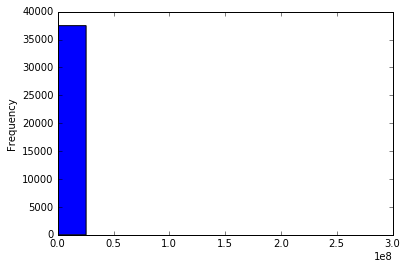

In [46]:
nyc["yearly_wages"].plot.hist()

the outliers are skewing our plot so we can't see much of the shape of the other data.  Let's remove our outliers, just to see the shape of the rest of our data.

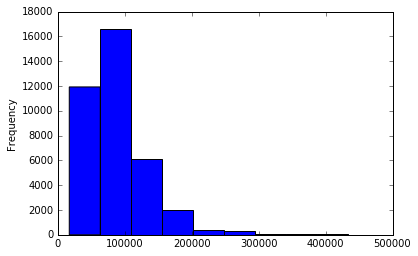

In [56]:
no_outlier_wages_nyc = nyc[nyc["yearly_wages"] < 500000]
no_outlier_wages_nyc["yearly_wages"].plot.hist()

In [59]:
len(nyc[nyc["yearly_wages"] < 100000]), len(nyc), len(nyc[nyc["yearly_wages"] < 100000]) / len(nyc)

(25879, 37499, 0.6901250700018667)

Interestingly about 70% of the data is less than 100000 per year.  My guess is that this data is normally distributed?  The amount of outliers though seems to be skewing the data far to the right.  It appears surprising to me that the pvalue for the normaltest would be 0, considering this data is clearly very skewed (as the test also indicates with the statistics).  My only guess, as to why we reject the null hypothesis is because of the size of the data.  Something about the asymptotics of the test for normality seems to giving enough evidence of highly skewed, but normal data.  In any event, clearly this data is _not_ normally distributed and the normal distribution moment generating function at the first and second level would produce biased estimators.  

Therefore we must entertain other possible distributions and moment generating functions in order to capture unbiased estimators.

In order to get a full picture of the data, I will employ both a bayesian and frequentist approach to get at descriptive statistics for the dataset.  First I will apply a bayesian method - creating a general mixture model of multiple distributions and then "fitting" the data to the distributions, making use of visuals to inspect how well the general mixing distribution captures the data's descriptive statistics.  Then I will make use of median and interquartile range to capture measures less sensitive to outliers.  

The reason I have chosen to capture both is because here the outliers matter.  It's not just how much the average worker in New York City makes versus Mountain View, it's how much the top tier worker makes as well.  This is because at the heart of this problem, I believe is the choice that H1B workers make when they choose to live in either New York City and Mountain View.  This choice will be determined, by amongst other thing their total potential earning power as well as their current realized earning power.  

Therefore, we must carefully consider both sets of motivations if we intend on saying anything meaningful about New York City and Mountain View and it's population of H1B workers.

In [91]:
import pomegranate as pom
nyc["yearly_wages"] = nyc["yearly_wages"].astype(float)
yearly_wages = [[elem] for elem in nyc["yearly_wages"]]
model = pom.GeneralMixtureModel.from_samples(
    [pom.NormalDistribution, pom.ExponentialDistribution],
    n_components=2, X=yearly_wages)
labels = model.predict(yearly_wages)
label_mapping = ["Normally Distributed", "Exponentially Distributed"]
for elem in zip(set(labels), np.bincount(labels)):
    print(label_mapping[elem[0]], elem[1])

Normally Distributed 36940
Exponentially Distributed 559


In [121]:
mu, std = model.distributions[0].parameters
Lambda = model.distributions[1].parameters[0]
print("The first model is normally distributed")
print("The first model's mean is", mu)
print("The first model's stardard deviation is", std)
print()
print("The second model is exponentially distributed")
print("The second model's mean is", 1/Lambda)
print("The second model's standard deviation is", 1/Lambda)
print("Overall yearly wages center", nyc["yearly_wages"].median())
print("Overall yearly wages spread", nyc["yearly_wages"].quantile(.75) - nyc["yearly_wages"].quantile(.25))

The first model is normally distributed
The first model's mean is 86205.77544713496
The first model's stardard deviation is 37785.587825405746

The second model is exponentially distributed
The second model's mean is 4679806.930660747
The second model's standard deviation is 4679806.930660747
Overall yearly wages center 75000.0
Overall yearly wages spread 46400.0


Now that we have a reasonable and nuanced description of our distribution, let's look at the Mountain View dataset.

In [114]:
first_work_location = df[df["lca_case_workloc1_state"] == "CA"]
second_work_location = df[df["lca_case_workloc2_state"] == "CA"]
loc1_cities = list(set(first_work_location["lca_case_workloc1_city"]))
loc2_cities = list(set(second_work_location["lca_case_workloc2_city"]))
total_cities = list(set(loc1_cities + loc2_cities))
total_cities = [city for city in total_cities if city is not np.nan]
for city in total_cities:
    if "view" in city.lower():
        print(city)

MOUNTAIN VIEW CITY
MOUNTAIN VIEW, CA
MOUNTAIN VIEW
MOUNTAIN VIEW,
MOUTAIN VIEW
GLENVIEW
MOUNATIN VIEW
MOUNTAINT VIEW
MOUNTAINVIEW
MOUNTAIN VIEW\
MOUNTAIN VIEW, CA 94043
MONTAIN VIEW
MOUNTIAN VIEW


As we can see, the naming issue is here as well, except less exaggerted.  So let's account for this.

In [116]:
mountain_view_names = [
    "MOUNTAIN VIEW CITY",
    "MOUNTAIN VIEW, CA",
    "MOUNTAIN VIEW",
    "MOUNTAIN VIEW,",
    "MOUTAIN VIEW",
    "MOUNATIN VIEW",
    "MOUNTAINT VIEW",
    "MOUNTAINVIEW",
    "MOUNTAIN VIEW\\",
    "MOUNTAIN VIEW, CA 94043",
    "MONTAIN VIEW",
    "MOUNTIAN VIEW"
]

def segment_to_mountain_view(x):
    if x in mountain_view_names:
        return True
    else:
        return False

mountain_view = df[df["lca_case_workloc1_city"].apply(segment_to_mountain_view)]
mountain_view.head()

,lca_case_number,status,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,other_wage_source_1,yr_source_pub_1,lca_case_workloc2_city,lca_case_workloc2_state,pw_2,pw_unit_2,pw_source_2,other_wage_source_2,yr_source_pub_2,lca_case_naics_code
288,I-200-10299-087885,WITHDRAWN,2010-10-27,2014-01-02,H-1B,2011-01-18,2014-01-17,GOOGLE INC.,1600 AMPHITHEATRE PARKWAY,MOUNTAIN VIEW,...,OFLC ONLINE DATA CENTER,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541512.0
1296,I-200-11074-036949,CERTIFIED-WITHDRAWN,2011-03-15,2013-10-30,H-1B,2011-04-04,2014-04-03,INTEGRAL DEVELOPMENT CORPORATION,2023 STIERLIN COURT,MOUNTAIN VIEW,...,OFLC ONLINE DATA CENTER,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,511200.0
1336,I-200-11075-508915,CERTIFIED-WITHDRAWN,2011-03-16,2014-04-14,H-1B,2011-09-11,2014-09-10,MICROSOFT CORPORATION,1 MICROSOFT WAY,REDMOND,...,OFLC ONLINE DATA CENTER,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51121.0
1648,I-200-11089-186173,WITHDRAWN,2011-03-30,2014-01-02,H-1B,2011-09-29,2014-09-28,GOOGLE INC.,1600 AMPHITHEATRE PARKWAY,MOUNTAIN VIEW,...,OFLC ONLINE DATA CENTER,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541512.0
1850,I-200-11101-672641,CERTIFIED-WITHDRAWN,2011-04-15,2014-03-07,H-1B,2011-10-01,2014-09-30,PRAMATI TECHNOLOGIES PRIVATE LIMITED,1975 W. EL CAMINO REAL,MOUNTAIN VIEW,...,OFLC ONLINE DATA CENTER,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541511.0


In [117]:
def to_yearly_wages(x):
    conversion_table = {
        "Hour": 1920,
        "Year": 1,
        "Week": 48,
        "Month": 11.25,
        "Bi-Weekly": 24
    }
    return conversion_table[x["lca_case_wage_rate_unit"]] * x["lca_case_wage_rate_from"]
    
mountain_view["yearly_wages"] = mountain_view.apply(to_yearly_wages, axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [119]:
mountain_view["yearly_wages"].min(), mountain_view["yearly_wages"].max()

(30000.0, 243840000.0)

It seems as though we have enough to start comparing.  The min and max salary are just a sanity check to make sure everything is in yearly salary.  

Let's dig further into the mountain view set, to see if we need to do anything special to fit the distribution.

In [123]:
below_500K_mv = mountain_view[mountain_view["yearly_wages"] < 50000]
above_500K_mv = mountain_view[mountain_view["yearly_wages"] >= 50000]

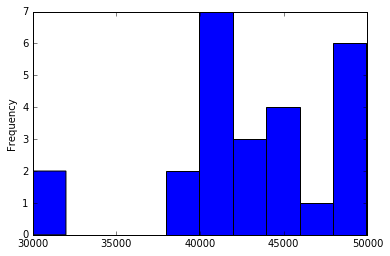

In [125]:
below_500K_mv["yearly_wages"].plot.hist()

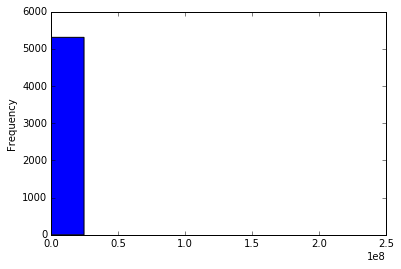

In [126]:
above_500K_mv["yearly_wages"].plot.hist()

So this data is likely not normally distributed.  Let's use the normaltest to make sure.

In [127]:
from scipy import stats
stats.normaltest(mountain_view["yearly_wages"])

NormaltestResult(statistic=13740.584834151119, pvalue=0.0)

Interestingly, this dataset appears far less skewed than nyc.  Both have a pvalue of 0.0, which again, I assume is an issue with the number of values.  The skew, kurtosis are still quiet, so I will proceed trying to fit a general mixing model.

In [131]:
import pomegranate as pom
mountain_view["yearly_wages"] = mountain_view["yearly_wages"].astype(float)
yearly_wages_mv = [[elem] for elem in mountain_view["yearly_wages"]]
model_mv = pom.GeneralMixtureModel.from_samples(
    [pom.NormalDistribution, pom.ExponentialDistribution],
    n_components=2, X=yearly_wages)
labels = model_mv.predict(yearly_wages)
label_mapping = ["Normally Distributed", "Exponentially Distributed"]
for elem in zip(set(labels), np.bincount(labels)):
    print(label_mapping[elem[0]], elem[1])

Normally Distributed 5329
Exponentially Distributed 11


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [130]:
len(mountain_view["yearly_wages"])

5340

So we've discovered a few interesting, althought not totally surprising things - one there are far more data points across NYC, as apposed to Mountain View.  Additionally, the data is mostly normally distributed like New York City.  Let's visually and textually explore the data further!

In [133]:
mu, std = model_mv.distributions[0].parameters
Lambda = model_mv.distributions[1].parameters[0]
print("The first model is normally distributed")
print("The first model's mean is", mu)
print("The first model's stardard deviation is", std)
print()
print("The second model is exponentially distributed")
print("The second model's mean is", 1/Lambda)
print("The second model's standard deviation is", 1/Lambda)
print("Overall yearly wages center", mountain_view["yearly_wages"].median())
print("Overall yearly wages spread", mountain_view["yearly_wages"].quantile(.75) - nyc["yearly_wages"].quantile(.25))

The first model is normally distributed
The first model's mean is 112414.21819067112
The first model's stardard deviation is 30061.09757077789

The second model is exponentially distributed
The second model's mean is 114508693.70532353
The second model's standard deviation is 114508693.70532353
Overall yearly wages center 110000.0
Overall yearly wages spread 70000.0


Let's look at New York City and Mountain View side by side:

NYC

```
The first model is normally distributed
The first model's mean is 86205.77544713496
The first model's stardard deviation is 37785.587825405746

The second model is exponentially distributed
The second model's mean is 4679806.930660747
The second model's standard deviation is 4679806.930660747
Overall yearly wages center 75000.0
Overall yearly wages spread 46400.0
```

Mountain View

```
The first model is normally distributed
The first model's mean is 112414.21819067112
The first model's stardard deviation is 30061.09757077789

The second model is exponentially distributed
The second model's mean is 114508693.70532353
The second model's standard deviation is 114508693.70532353
Overall yearly wages center 110000.0
Overall yearly wages spread 70000.0
```

So we can see that for both distributions, New York City is lower in terms of average salary.  This is also true overall.  While this may seem like a surprising result, if you consider the relative size of the two datasets as well as the housing situation in both areas things start to make sense.

Let's first reminder ourselves of the size of New York City and Mountain View H1B visas:

In [135]:
len(nyc), len(mountain_view), len(nyc) / len(mountain_view)

(37499, 5340, 7.022284644194756)

So nyc is approximately 7 times larger than mountain view in the number of applications.  So we can conclude at least some of the difference hear is _because_ while top tech talent is certainly going to mountain view, a lot of equivalent folks are also going to nyc.  It's just that folks at a lower skill level are also going to nyc.  The market is nyc is bigger, so it has more variability, but doesn't skew as strongly to higher salaries.  

So why is this happening?  My belief at this is due to cost of living.  San Francisco generally has a housing crisis and Mountain View is certainly part of that.  They are over saturated, so rents are very, very high.  Therefore, if you want to hire someone you have to pay them enough to make it worth while.  In terms of order of magnitude, NYC and Mountain View are more or less on par, but the carrying capacity of Mountain View is much lower.  

To show that these distributions are similar overall, we make use of the mann whitney U-Test, which checks if two distributions are similar.

In [138]:
from scipy import stats

stats.mannwhitneyu(nyc["yearly_wages"], mountain_view["yearly_wages"])

MannwhitneyuResult(statistic=54381812.0, pvalue=0.0)

As we can see, we reject the null hypothesis and therefore, the distributions are the same!  So the obvious question - why are the distributions the same?  I think that Mountain View is strongly a technology ecosystem and New York is becoming more and more technology focused.

## Question Three 

Problem Definition:

For NYC, what is the relationship between the total number of H­1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship?

Breaking this down a bit - The variables of interest are:

* The total number of H1B visas requested by an employer
* The average wages for that employer

Task: Visually represent this relationship

Question: Is the relationship statistically significant?

If you recall from part one, company names are not consistent across the companies.  So company X might have 5 or even 10 different names, that all refer semantically to the same company.  Earlier we solved this with hard coding the names of these companies.  But now, we'll need a general way to map company names to a canonical form, so that we can assess this relationship in general, rather than for a specific company.

In the past I tried finding a single word that mapped a company name semantically.  A good example of a type of company this works for is Barclays.  If the name Barclays appears in the company name, we can be reasonably sure they are the same company.  However, finding the one general word that corresponds semantically in general proved elusive.  So now I will take on a different tact.


In [9]:
len(nyc) / len(nyc["lca_case_employer_name"].unique())

3.662727095135769

Our first win comes from just looking at the unique employer names.  We can reduce the number of businesses we need to classify by approximate 3.66 fold, just by looking at only unique names!

In [77]:
from collections import OrderedDict
h1b_nyc = nyc[nyc["visa_class"] == "H-1B"]
employers = list(h1b_nyc["lca_case_employer_name"].unique())
value_counts = {}.fromkeys(employers, 0)
for employer in employers:
    tmp_df = h1b_nyc[h1b_nyc["lca_case_employer_name"] == employer]
    for index in tmp_df.index:
        value_counts[employer] += tmp_df.ix[index]["total_workers"]
value_counts = OrderedDict(sorted(value_counts.items(), key=lambda t: t[1], reverse=True))

In [78]:
true_counts = {
    "PRICEWATERHOUSECOOPERS": 0,
    "MPHASIS": 0,
    "ERNST & YOUNG": 0,
    "TATA": 0,
    "CHASE": 0,
    "INFOSYS": 0,
    "MORGAN STANLEY": 0, 
    "GOLDMAN": 0,
    "DELOITTE": 0,
    "BLOOMBERG": 0,
    "CREDIT SUISSE": 0,
    "CITI": 0,
    "COLUMBIA UNIVERSITY": 0,
    "GOOGLE": 0,
    "WIPRO": 0,
    "LARSEN & TOUBRO": 0,
    "BARCLAYS": 0,
    "MOUNT SINAI": 0,
    "CAPGEMINI": 0,
    "KPMG": 0, 
    "DEUTSCHE": 0,
    "MEMORIAL SLOAN-KETTERING": 0,
    "NEW YORK UNIVERSITY": 0,
    "HEADSTRONG": 0,
    "BANK OF AMERICA": 0,
    "IGATE": 0,
    "BLACKROCK": 0,
    "ACCENTURE": 0,
    "MERRILL LYNCH": 0,
    "CORNELL": 0,
    "ST. BARNABAS": 0,
    "MONTEFIORE": 0,
    "UBS": 0,
    "BRONX-LEBANON": 0,
    "NEW YORK CITY DEPARTMENT OF EDUCATION": 0,
    "GRANDISON": 0,
    "BILINGUALS": 0,
    "MINDTREE": 0,
    "RBC": 0,
    "POLARIS": 0,
    "ITNEWTON": 0,
    "SYNTEL": 0,
    "CSC COVANSYS": 0,
    "HCL": 0,
    "BOSTON": 0,
    "EXECU|SEARCH": 0,
    "MCKINSEY": 0,
    "BIRLASOFT": 0,
    "IDEO": 0,
    "JEFFERIES": 0,
    "NESS": 0,
    "RCM": 0,
    "ZS": 0,
    "FUJITSU": 0,
    "ORACLE": 0
}

employers_excluded = []
for employer in value_counts:
    for true_employer in true_counts:
        if true_employer in employer:
            employers_excluded.append(employer)
            true_counts[true_employer] += value_counts[employer]
for employer in value_counts:
    if employer not in employers_excluded:
        true_counts[employer] = value_counts[employer]
true_counts = OrderedDict(sorted(true_counts.items(), key=lambda t: t[1], reverse=True))
len(true_counts)

8899

In [79]:
from fuzzywuzzy import fuzz
counts = 0
pairs = []
employers = list(true_counts.keys())
for index, employer in enumerate(employers):
    tmp = employers[:index] + employers[index+1:]
    for elem in tmp:
        if fuzz.ratio(elem, employer) > 95:
            counts += 1
            pairs.append((elem, employer))
counts

1126

So it looks like 1126 of these company names are likely just misspellings of one another and so can be collapsed into one another!  There might be more optimizations than this, but in the interest of time, I won't pursue them.  

Another reason I believe this level of optimization to be defensible - smaller businesses are less likely to have multiple company names.  I'm assuming that the size of the business is related to the number of H1B visas the company requests.  Therefore if the company size is small, there is likely only one semantic name for the company.  

So, if we account for spelling errors, which is what I'm hoping the fuzzy matching accounts for, then we should have no semantic company names appearing twice.  Let's verify that our fuzzy matching only produces misspellings of the same name by looking at some cases.

In [35]:
pairs[:100]

[('SG AMERICAS SECURITIES LLC', 'SG AMERICAS SECURITIES, LLC'),
 ('SG AMERICAS SECURITES, LLC', 'SG AMERICAS SECURITIES, LLC'),
 ('THE VERITAS HEALTHCARE SOLUTIONS LLC',
  'THE VERITAS HEALTHCARE SOLUTIONS, LLC'),
 ('THOMSON REUTERS MARKETS LLC', 'THOMSON REUTERS (MARKETS) LLC'),
 ('TECH MAHINDRA (AMERICAS), INC.', 'TECH MAHINDRA ( AMERICAS), INC'),
 ("STANDARD &POOR'S FINANCIAL SERVICES LLC",
  "STANDARD & POOR'S FINANCIAL SERVICES LLC"),
 ("STANDARD POOR'S FINANCIAL SERVICES LLC",
  "STANDARD & POOR'S FINANCIAL SERVICES LLC"),
 ('TECH MAHINDRA ( AMERICAS), INC', 'TECH MAHINDRA (AMERICAS), INC.'),
 ('TECH MAHINDRA (AMERICAS) INC.', 'TECH MAHINDRA (AMERICAS), INC.'),
 ('TECH MAHINDRA (AMERICAS),INC.', 'TECH MAHINDRA (AMERICAS), INC.'),
 ('TECH MAHINDRA (AMERICAS), INC.', 'TECH MAHINDRA (AMERICAS) INC.'),
 ('TECH MAHINDRA (AMERICAS),INC.', 'TECH MAHINDRA (AMERICAS) INC.'),
 ('D.E. SHAW & CO., L.P.', 'D. E. SHAW & CO., L.P.'),
 ('PRIME HEALTHCARE SERVICES, INC.', 'PRIME HEALTHCARE SERVIC

Visually inspecting the first hundred pairs feels pretty convincing to me.  I think this gives us a pretty good second set!  Alright, so now all we need to do is map the true counts of the pairs and then we'll have a good representation of the total number visas per employer.  Then we'll be a good place to look at average salary!

In [80]:
seen_keys = []
name_mapping = {}
for pair in pairs:
    if pair[0] in seen_keys:
        name_mapping[pair[0]].append(pair[1])
    else:
        name_mapping[pair[0]] = [pair[1]]

In [81]:
true_counts = {
    "PRICEWATERHOUSECOOPERS": 0,
    "MPHASIS": 0,
    "ERNST & YOUNG": 0,
    "TATA": 0,
    "CHASE": 0,
    "INFOSYS": 0,
    "MORGAN STANLEY": 0, 
    "GOLDMAN": 0,
    "DELOITTE": 0,
    "BLOOMBERG": 0,
    "CREDIT SUISSE": 0,
    "CITI": 0,
    "COLUMBIA UNIVERSITY": 0,
    "GOOGLE": 0,
    "WIPRO": 0,
    "LARSEN & TOUBRO": 0,
    "BARCLAYS": 0,
    "MOUNT SINAI": 0,
    "CAPGEMINI": 0,
    "KPMG": 0, 
    "DEUTSCHE": 0,
    "MEMORIAL SLOAN-KETTERING": 0,
    "NEW YORK UNIVERSITY": 0,
    "HEADSTRONG": 0,
    "BANK OF AMERICA": 0,
    "IGATE": 0,
    "BLACKROCK": 0,
    "ACCENTURE": 0,
    "MERRILL LYNCH": 0,
    "CORNELL": 0,
    "ST. BARNABAS": 0,
    "MONTEFIORE": 0,
    "UBS": 0,
    "BRONX-LEBANON": 0,
    "NEW YORK CITY DEPARTMENT OF EDUCATION": 0,
    "GRANDISON": 0,
    "BILINGUALS": 0,
    "MINDTREE": 0,
    "RBC": 0,
    "POLARIS": 0,
    "ITNEWTON": 0,
    "SYNTEL": 0,
    "CSC COVANSYS": 0,
    "HCL": 0,
    "BOSTON": 0,
    "EXECU|SEARCH": 0,
    "MCKINSEY": 0,
    "BIRLASOFT": 0,
    "IDEO": 0,
    "JEFFERIES": 0,
    "NESS": 0,
    "RCM": 0,
    "ZS": 0,
    "FUJITSU": 0,
    "ORACLE": 0
}

employers_excluded = []
for employer in value_counts:
    for true_employer in true_counts:
        if true_employer in employer:
            employers_excluded.append(employer)
            true_counts[true_employer] += value_counts[employer]

for employer in value_counts:
    if employer not in employers_excluded:
        if employer in name_mapping:
            other_names = name_mapping[employer]
            true_counts[employer] = value_counts[employer]
            for other_name in other_names:
                true_counts[employer] += value_counts[other_name]
len(true_counts)

1087

Now all we need is to follow the same procedude for salaries and then we'll be set!

In [63]:
from collections import OrderedDict
def to_yearly_wages(x):
    conversion_table = {
        "Hour": 1920,
        "Year": 1,
        "Week": 48,
        "Month": 11.25,
        "Bi-Weekly": 24
    }
    return conversion_table[x["lca_case_wage_rate_unit"]] * x["lca_case_wage_rate_from"]

h1b_nyc = nyc[nyc["visa_class"] == "H-1B"]
h1b_nyc["yearly_wages"] = h1b_nyc.apply(to_yearly_wages, axis=1)
employers = list(h1b_nyc["lca_case_employer_name"].unique())
value_wages = {}.fromkeys(employers, 0)
for employer in employers:
    tmp_df = h1b_nyc[h1b_nyc["lca_case_employer_name"] == employer]
    for index in tmp_df.index:
        sum_of_wages = tmp_df.ix[index]["yearly_wages"] * tmp_df.ix[index]["total_workers"]
        value_wages[employer] += sum_of_wages
value_wages = OrderedDict(sorted(value_wages.items(), key=lambda t: t[1], reverse=True))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [64]:
true_wages = {
    "PRICEWATERHOUSECOOPERS": 0,
    "MPHASIS": 0,
    "ERNST & YOUNG": 0,
    "TATA": 0,
    "CHASE": 0,
    "INFOSYS": 0,
    "MORGAN STANLEY": 0, 
    "GOLDMAN": 0,
    "DELOITTE": 0,
    "BLOOMBERG": 0,
    "CREDIT SUISSE": 0,
    "CITI": 0,
    "COLUMBIA UNIVERSITY": 0,
    "GOOGLE": 0,
    "WIPRO": 0,
    "LARSEN & TOUBRO": 0,
    "BARCLAYS": 0,
    "MOUNT SINAI": 0,
    "CAPGEMINI": 0,
    "KPMG": 0, 
    "DEUTSCHE": 0,
    "MEMORIAL SLOAN-KETTERING": 0,
    "NEW YORK UNIVERSITY": 0,
    "HEADSTRONG": 0,
    "BANK OF AMERICA": 0,
    "IGATE": 0,
    "BLACKROCK": 0,
    "ACCENTURE": 0,
    "MERRILL LYNCH": 0,
    "CORNELL": 0,
    "ST. BARNABAS": 0,
    "MONTEFIORE": 0,
    "UBS": 0,
    "BRONX-LEBANON": 0,
    "NEW YORK CITY DEPARTMENT OF EDUCATION": 0,
    "GRANDISON": 0,
    "BILINGUALS": 0,
    "MINDTREE": 0,
    "RBC": 0,
    "POLARIS": 0,
    "ITNEWTON": 0,
    "SYNTEL": 0,
    "CSC COVANSYS": 0,
    "HCL": 0,
    "BOSTON": 0,
    "EXECU|SEARCH": 0,
    "MCKINSEY": 0,
    "BIRLASOFT": 0,
    "IDEO": 0,
    "JEFFERIES": 0,
    "NESS": 0,
    "RCM": 0,
    "ZS": 0,
    "FUJITSU": 0,
    "ORACLE": 0
}

employers_excluded = []
for employer in value_wages:
    for true_employer in true_wages:
        if true_employer in employer:
            employers_excluded.append(employer)
            true_wages[true_employer] += value_wages[employer]
for employer in value_wages:
    if employer not in employers_excluded:
        true_wages[employer] = value_wages[employer]
true_wages = OrderedDict(sorted(true_wages.items(), key=lambda t: t[1], reverse=True))
len(true_wages)

8899

In [65]:
from fuzzywuzzy import fuzz
counts = 0
pairs = []
employers = list(true_wages.keys())
for index, employer in enumerate(employers):
    tmp = employers[:index] + employers[index+1:]
    for elem in tmp:
        if fuzz.ratio(elem, employer) > 95:
            counts += 1
            pairs.append((elem, employer))
counts

1126

In [67]:
true_wages = {
    "PRICEWATERHOUSECOOPERS": 0,
    "MPHASIS": 0,
    "ERNST & YOUNG": 0,
    "TATA": 0,
    "CHASE": 0,
    "INFOSYS": 0,
    "MORGAN STANLEY": 0, 
    "GOLDMAN": 0,
    "DELOITTE": 0,
    "BLOOMBERG": 0,
    "CREDIT SUISSE": 0,
    "CITI": 0,
    "COLUMBIA UNIVERSITY": 0,
    "GOOGLE": 0,
    "WIPRO": 0,
    "LARSEN & TOUBRO": 0,
    "BARCLAYS": 0,
    "MOUNT SINAI": 0,
    "CAPGEMINI": 0,
    "KPMG": 0, 
    "DEUTSCHE": 0,
    "MEMORIAL SLOAN-KETTERING": 0,
    "NEW YORK UNIVERSITY": 0,
    "HEADSTRONG": 0,
    "BANK OF AMERICA": 0,
    "IGATE": 0,
    "BLACKROCK": 0,
    "ACCENTURE": 0,
    "MERRILL LYNCH": 0,
    "CORNELL": 0,
    "ST. BARNABAS": 0,
    "MONTEFIORE": 0,
    "UBS": 0,
    "BRONX-LEBANON": 0,
    "NEW YORK CITY DEPARTMENT OF EDUCATION": 0,
    "GRANDISON": 0,
    "BILINGUALS": 0,
    "MINDTREE": 0,
    "RBC": 0,
    "POLARIS": 0,
    "ITNEWTON": 0,
    "SYNTEL": 0,
    "CSC COVANSYS": 0,
    "HCL": 0,
    "BOSTON": 0,
    "EXECU|SEARCH": 0,
    "MCKINSEY": 0,
    "BIRLASOFT": 0,
    "IDEO": 0,
    "JEFFERIES": 0,
    "NESS": 0,
    "RCM": 0,
    "ZS": 0,
    "FUJITSU": 0,
    "ORACLE": 0
}

employers_excluded = []
for employer in value_wages:
    for true_employer in true_wages:
        if true_employer in employer:
            employers_excluded.append(employer)
            true_wages[true_employer] += value_wages[employer]

for employer in value_wages:
    if employer not in employers_excluded:
        if employer in name_mapping:
            other_names = name_mapping[employer]
            true_wages[employer] = value_wages[employer]
            for other_name in other_names:
                true_wages[employer] += value_wages[other_name]
len(true_wages)

1087

Okay! So we have wages per employer!  Additionally we have the total number of H1B visas per employer.  Let's look at the relationship between our two variables!

Let's start by creating two lists, indexed by company name.  

In [98]:
from scipy import stats
wages = []
counts = []
for company in average_wages:
    wages.append(true_wages[company])
    counts.append(true_counts[company])
stats.pearsonr(wages, counts)

(0.38334012597028128, 2.2490912071152001e-39)

We clearly see a statistically significant relationship here, the pvalue is far below the 0.05 cut off value.  So we can say the correlation is statistically significant and positive.

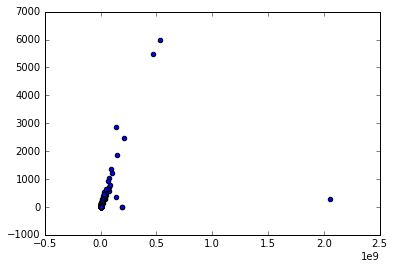

In [99]:
plt.scatter(wages, counts)
plt.show()

There is a clear and positive relationship between wages and the number of H1B visas requested!  Filling H1B visas costs money - according to this source: https://www.upcounsel.com/blog/what-is-the-costs-for-an-employer-to-sponsor-an-h1b-visa it's about $5000 per application.  So the companies with the biggest wallets will be the most likely to hire purely based on talent and not consider cost.  They can afford to pay more for employees.  They also have the highest possible carrying capacity of employees - some companies, especially those which are more sensitive to cost per employee, are likely to have low carry capacity.  Formally, I define carrying capacity as how many new hires a company can take on and continue to function.  So if a firm is able to sustain a large workforce over the medium term, then we say it has a high or large carrying capacity.

Additionally, this means they are likely to pay more, since they are optimizing for the highest number of talented candidates.  A part of being able to pay more in fees is probably also being able to afford to pay very high salaries.  After all, those with H1B visas are considering, in theory, every company in the world.  So the salary would need to be high, to attract those candidates.  

So this positive relationship makes sense.  

In [100]:
df.columns

Index(['lca_case_number', 'status', 'lca_case_submit', 'decision_date',
       'visa_class', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'lca_case_employer_name',
       'lca_case_employer_address', 'lca_case_employer_city',
       'lca_case_employer_state', 'lca_case_employer_postal_code',
       'lca_case_soc_code', 'lca_case_soc_name', 'lca_case_job_title',
       'lca_case_wage_rate_from', 'lca_case_wage_rate_to',
       'lca_case_wage_rate_unit', 'full_time_pos', 'total_workers',
       'lca_case_workloc1_city', 'lca_case_workloc1_state', 'pw_1',
       'pw_unit_1', 'pw_source_1', 'other_wage_source_1', 'yr_source_pub_1',
       'lca_case_workloc2_city', 'lca_case_workloc2_state', 'pw_2',
       'pw_unit_2', 'pw_source_2', 'other_wage_source_2', 'yr_source_pub_2',
       'lca_case_naics_code'],
      dtype='object')